In [1]:
import os 
import torch
from data_loaders import dataset_loader
from sklearn.preprocessing import scale
from functions import *
from sensibility_structure import * 
import matplotlib.pyplot as plt
from mDAE_function import * 

2024-04-07 17:44:14.268606: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-07 17:44:15.036389: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="6"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# How to use the mDAE algorithm ?

In this notebook we present the different steps to use our method of missing data imputation : the mDAE. To make the notebook coherent and useful we add a part on missing data artificially generated.

<b>Warning :  you do not need to have a true dataset (without missing data) to use mDAE algorithm. </b>
We load in this exemple a complete dataset because it is a dataset that everyone can load.

## The data 

We construct this exemple around dataset downloaded on the UCI website. Pytorch is used in the code.
In the file data_loaders.py there is a function "dataset_loader" that we use to load the dataset in a folder named "datasets". 

In [3]:
if not os.path.isdir("datasets"):
    os.mkdir("datasets")

name_data = "breast_cancer_diagnostic"

ground_truth = scale(dataset_loader(name_data)) # "wine" can be replaced with any of the datasets
                                             # supported by dataset_loader (see data_loaders.py)
#ground_truth = dataset_loader("libras")
X_true = torch.from_numpy(ground_truth)
X_true = X_true.float()
X_true = X_true.to(device)

Now we can put artificially missing data. In the article we propose 4 ways to generate missing data. We choose to use the same generation strategy detailed in https://github.com/BorisMuzellec/MissingDataOT for MAR and MNAR. 
For each mechanism you need to initialize some variables. The explanation of MAR and MNAR are in github cited previously. 
Overall you need the percent of missing data to put in the dataset, the number of columns and the number of rows. 

The outputs of these functions are : 
<ul>
  <li> <b>x</b> : the dataset pre-imputed by 0 (mean of the columns). The neural networks do not take datasets with NA's as input so we need to make pre-imputation </li>
  <li> <b>nb_cases_na</b> : number of elements chosen to be NA </li>
  <li> <b>ind_rows_na</b> and <b>ind_columns_na</b> : the indices of the two list at the same position give the position of missing data in <b>x</b> </li>
  <li> <b>list_no_na_col</b> : each row of this tab give the position of an element that have not be chosen to be NA </li>
</ul>

In [4]:
version_NA = "MCAR" #choose the kind of missing data you have to generate 
m = 0.2 #percent of missing data generated 
nb_col = X_true.size(1) 
nb_rows = X_true.size(0)



if version_NA == "MCAR" : 
    x, nb_cases_na, ind_rows_na, ind_columns_na, list_no_na_col = missing_data_MCAR(X_true,m,nb_col,nb_rows) #function implemented in functions.py 

if version_NA == "MAR":
    x, nb_cases_na, ind_rows_na, ind_columns_na, list_no_na_col = missing_data_MAR(X_true, m, prop_var, nb_col, nb_rows) #function implemented in functions.py 

if version_NA == "MNAR" : 
    x, nb_cases_na, ind_rows_na, ind_columns_na, list_no_na_col = missing_data_MNAR(X_true, m, prop_var, nb_col, nb_rows, exclude_inputs = True) #function implemented in functions.py 

if version_NA == "blocks" : 
    x, nb_cases_na, ind_rows_na, ind_columns_na, list_no_na_col = missing_data_blocks(X_true, m, taille_block, nb_col, nb_rows) #function implemented in functions.py 

## Choice of the AE structure 

We propose in this notebook a procedure to select the best structure of the AE that will suits the best for the dataset. We propose 6 structures like in the article to compare them. 
The first two ones are undercomplete structures and the four next ones are overcomplete. 

In the last four you can find different number of nodes and layers. 

Warning : undercomplete structure may not function on small datasets (change the number of layer and nodes in the functions_structure.py file)

In [5]:
#parameters for structure choice 
grid_mu = [0.05,0.1,0.2,0.3,0.4,0.5] #see in the article mu is an hyper parameter optimized in the mDAE prodedure
nb_mu = len(grid_mu)
nb_iter = 1 #number of repetitions to optimize mu 
    
prop_data_validation = 0.2 #proportion of the data used to optimize mu 
batch_size = 80
learning_rate = 1e-3
epochs_mdae = 600

This function will load a .pt for each structure that is tested. 
This function is in sensibility_structure.py. 

In [6]:
sensibility_struct(x, grid_mu, nb_iter,nb_rows,nb_col,nb_cases_na,ind_rows_na,ind_columns_na,list_no_na_col,prop_data_validation, epochs_mdae,batch_size,learning_rate)

mdae struct1 
mdae struct2 
mdae struct3 
mdae struct4 
mdae struct5 
mdae struct6 


## Results

In this section we show the results to choose the best structure. 

In [7]:
#loading 
methods_bis = ["struct1", "struct2", "struct3", "struct4", "struct5", "struct6"]
dicto = {me : [] for me in methods_bis }

for me in methods_bis : 
    dicto[me].append(torch.load(f"data_boxplot_mdae_{me}.pt"))

In [8]:
#to compute the error between reconstruction and true values, we load true values 
data_boxplot_true= torch.zeros([nb_cases_na])
data_boxplot_true[:] = X_true[ind_rows_na,ind_columns_na]

In [9]:

dicto_height = {me : [None,None] for me in methods_bis }


for me in methods_bis : 
    a = torch.zeros([1])
    a[0] = (1/data_boxplot_true.shape[0])*(torch.abs(data_boxplot_true -  dicto[me][0]).sum())

    dicto_height[me][0] = torch.mean(a)
    dicto_height[me][1] = torch.std(a)
  
dicto_height = torch.tensor(list(dicto_height.values()))
    

In [10]:
#names of the 
bars = ["struct1","struct2","struct3","struct4","struct5","struct6"]

/home/mdupuy/.local/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/home/mdupuy/.local/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
/home/mdupuy/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1335: RuntimeWarning: invalid value encountered in cast
  return np.asarray(x, float)


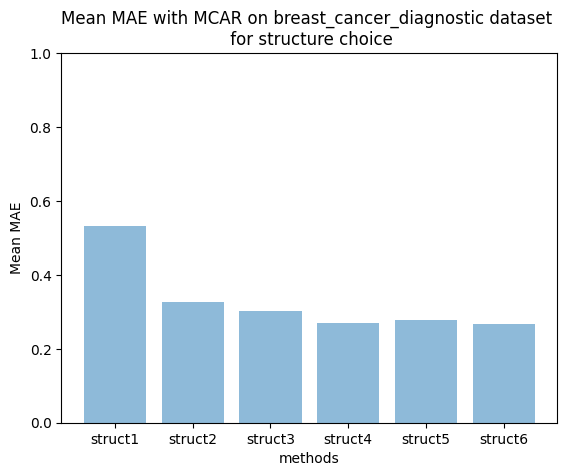

In [11]:
y_pos = np.arange(len(bars))

# Create bars
plt.bar(y_pos, dicto_height[:,0], yerr=dicto_height[:,1], align='center', alpha=0.5, ecolor='black', capsize=10)

# Add title and axis names
plt.title(f'Mean MAE with {version_NA} on {name_data} dataset \n for structure choice')
plt.xlabel('methods')
plt.ylabel('Mean MAE')

plt.ylim(0,1)
# Create names on the x-axis
plt.xticks(y_pos, bars)

# Show graphic
plt.show()

Now you can choose the number of the structure (between 0 and 5). 

If there is no true data available to test the sensibility of the structure on your data, we advise you to choose an overcomplete structure like the number 3. 

In [ ]:
number_structure = 4

## Run the mDAE method

Now we have the structure we can run the mDAE to have the imputation of the dataset. 
With the function mDAE you load one .pt. "NA_reconstructed_from_mDAE.pt" with the values computed by the mDAE at the position of <b>ind_rows_na</b> and <b>ind_columns_na</b>.

It is possible to change the parameters of the function mDAE. Usually we keep the same that the one chosen for the structure choice. 

In [ ]:
#parameters for structure choice 
grid_mu = [0.05,0.1,0.2,0.3,0.4,0.5] #see in the article mu is an hyper parameter optimized in the mDAE prodedure
nb_mu = len(grid_mu)
nb_iter = 1 #number of repetitions to optimize mu 
    
prop_data_validation = 0.2 #proportion of the data used to optimize mu 
batch_size = 80
learning_rate = 1e-3
epochs_mdae = 600

In "x_imputed" you can have the scaled dataset imputed with the mDAE method.

In [ ]:
x_imputed = mDAE(x, nb_col, nb_rows, nb_iter,prop_data_validation,list_no_na_col,ind_rows_na,ind_columns_na,epochs_mdae,batch_size,learning_rate, grid_mu,nb_cases_na,number_structure)